<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Solving_Differential_Equations_with_NNs/03_solving_differential_equations_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 3: Solving Differential Equations with Neural Networks

## Introduction

An important result to come from studying neural networks is a theorum known as the Universal Approximation Theorem.  It states that a neural network with one hidden layer and a finite number of neurons can approximate any function to any given accuracy.  Of course in practice it may be hard to train a neural network to an accuracy wanted, but we can generally get the accuracy relatively high.  

The Universal Approximation Theorem is important for this module because we will be using it to validate the use of neural networks to model the position of an object.  We will do this given only the acceleration of the object and will work up to creating a neural network that models the position.  In doing so, we will be creating a neural network that solves the following differential equation:

$$\frac{d^2y}{dt^2} = a(t,v,y,\vec{c}),$$

where the acceleration of the object, a, may be a function of time, velocity, position, and/or any constants $\vec{c}$.

The below code cells walk you through the process of setting up a neural network that will solve a second order differential equation (in this case using acceleration to find position).  We will compare the results from the neural network to both the exact solution and the results from numerically solving the differential equation using the Velocity-Verlet method (the most accurate of the numerical differential equation solvers investigated).

## Overview of Solving Differential Equations with Neural Networks

When solving differential equations with neural networks, we assume that the neural network will approximate the function that we are trying to solve and we train the neural network so that its n-th derivative matches the nth-order differential equation we are trying to solve.  For example, when solving for position given acceleration, we can formulate this as a second order differential equation.  Therefore, when we are approximating the position on an object with a neural network, we want to train the network such that its second derivative is as close to the known acceleration as possible.

Deriving a neural network may seem like an abstract concept, but the same automatic differentiation library we used in Notebook 2 (JAX) can be used to derive a neural network.

In [1]:
# IMPORTS
# Math for the ceiling function
from math import ceil
# Matplotlib for graphing capabilities
from matplotlib import pyplot as plt
import numpy as np
# Modules from the JAX library for creating neural networks
import jax.numpy as jnp
from jax import grad
from jax import random as npr

## Support Function

The below two code cells define a function that calculates the root mean-squared error between two NumPy arrays (for error analysis) and the a common activation function for neural networks (the sigmoid function).

In [2]:
def rmse(A,B):
    """
        Inputs:
            A,B (NumPy arrays)
        Returns:
            Unnamed (a float): the RMSE error between A and B
        Calculates the RMSE error between A and B.
    """
    assert len(A)==len(B),"The data sets must be the same length to calcualte\
        the RMSE."
    return np.sqrt(np.average((A-B)**2)) 

In [3]:
def sigmoid(x):
    """
        Calculates the value of the sigmoid function for 
        a given input of x
    """
    return 1. / (1. + jnp.exp(-x))

## Defining the Model

Now let's define the analytic solution for our position as well as the Velocity-Verlet solution.  The code in the next two cells is taken from the first notebook in this module (Notebook 1: Solving Differential Equations Numerically).  Please see that notebook for a review of these code cells if needed.  The difference is that we define y=0 to be where the object is released in the air (since coordinate systems are arbitrary this is fine).

In [4]:
def y_analytic(t, b, m):
    """
        Inputs:
            t (a 1D NumPy array): the times to calculate the exact position at
            b (a float): the linear drag coefficient
            m (a float): the mass of the object
        Returns:
            y_exact (a 1D NumPy array): the exact y position of the object at 
                each time step
        Calculates the exact position for an object in freefall with linear drag
    """
   # Define the gravitational constant
    g = -9.81

    # Set up the initial conditions (velocity and height)
    v_0 = 0
    y_0 = 0

    # Define the termminal velocity and the characteristic time
    v_ter = m*g/b
    tau = v_ter/g

    # Define and return the exact solution
    y_exact = v_ter*t + (v_0-v_ter)*tau*(1-np.exp(-t/tau))+y_0
    return y_exact

In [5]:
def velocity_verlet (b,m,DeltaT,tfinal):
    """
        Inputs:
            b (a float): the linear drag coefficient
            m (a float): the mass of the object
            DeltaT (a float): the time step to calculate the position at
            tfinal (a float): the last time to calculate the position at
        Returns:
            y_vv (a 1D NumPy array): the predicted position of the object at 
                each time step, calculated using the Velocity-Verlet method
        Predicts the position of an object in freefall with linear drag using the
        Velocity-Cerlet method for solving differential equations
    """
    # Define the near Earth gravitational constant
    g = -9.81

    # set up arrays 
    n = ceil(tfinal/DeltaT) #Assuming tinitial=0

    # set up arrays for t, a, v, and y and we can compare our results with analytical ones
    t = np.zeros(n)
    a = np.zeros(n)
    v = np.zeros(n)
    y_vv = np.zeros(n)

    # Initial conditions (Change these if needed)
    v[0] = 0.0  #m/s
    y_vv[0] = 0.0 #m

    # Start integrating using Euler-Cromer
    for i in range(n-1):
        # expression for acceleration
        a[i] = g - (b/m)*v[i]
        # update position
        y_vv[i+1] = y_vv[i] + v[i]*DeltaT + 0.5*a[i]*DeltaT**2
        # updated expression for acceleration
        a[i+1] = g - (b/m)*v[i+1]
        # update velocity
        v[i+1] = v[i] + 0.5*DeltaT*(a[i+1] + a[i])
        # update time to next time step and compute analytical answer
        t[i+1] = t[i] + DeltaT

    return y_vv

## Define the Acceleration

The below function defines the acceleration for an object in free fall with linear drag.  The acceleration here depends only on the velocity of the object and the linear drag coefficient, b.

In [6]:
def acceleration(v, b):
    """
        Inputs:
            t (a float): the time to calculate the acceleration at
            v (a float): the velocity at time t
            b (a float): the linear drag coefficient
        Returns:
            Unnamed (a float): the acceleration for the given set
                of parameters
        Calculates and returns the acceleration of the object at a given time t
    """
    g = -9.81 #m/s^2
    return g-b*v

## Creating the Neural Network

Now let's create a neural network that has one hidden layer and uses the sigmoid activation function on the hidden layer and no activation function on the outer layer.  If the below code seems unfamiliar, go back and look through the second notebook of this module (Notebook 2: What is a Neural Network?).

In [7]:
def neural_network(W, x):
    """
        Inputs:
            W (a list of length 2): the weights of the neural 
                network
            x (a float): the input value of the neural network
        Returns:
            Unnamed (a float): The output of the neural network
        Defines a neural network with one hidden layer.  The 
        number of neurons in the hidden layer is the length of 
        W[0]. The activation function is the sigmoid function 
        on the hidden layer an none on the output layer.
    """
    # Calculate the output for the neurons in the hidden layer
    hidden_neuron = sigmoid(jnp.dot(x, W[0]))
    # Calculate the result for the output neuron
    return jnp.dot(hidden_neuron, W[1])

## Trial Position

The below function defines the trial position as a function of the neural network (a general form we assume the equation for the position will take that will be fine-tuned by training the neural network).  Here we are assuming that we know the starting position y(t=0) and the starting velocity v(t=0), making this an initial value problem.  Let's assume that your trial solution has the form:

$$y_{trial}(t) = A + Bt + t^2NN(W,t),$$

where A and B are a constants set by the initial conditions and NN is the output of the neural network that depends on both the weights (W) and the time.  As it turns out, A = y(t=0) and B = v(t=0) (both of which will be zero in the specific case of this problem).  This makes the final form of our trial solution:

$$y_{trial}(t) = t^2NN(W,t).$$

Note that we could have used any trial solution for the position as long as it satisfied the initial conditions.  The choice for this particular form of trial solution is discussed [here](https://arxiv.org/pdf/physics/9705023.pdf), though the mathematics can get a bit complicated in places.

In [8]:
def y_trial(ti, nn):
    """
        Inputs:
            ti (a float): the time to calcualte the position at
            nn (a float): the neural network prediction at time ti
        Returns:
            Unnamed (a float): The neural network prediction for the position at
                the given time
        The neural network preduction for the position of the object
    """
    return ti**2 * nn

# The trial velocity is the derivative of the trial position   
v_trial = grad(y_trial)
# The trial acceleration is the derivative of the trial velocity
a_trial = grad(v_trial)

## Defining the Loss Function

The loss function is a function that will have a minimum (preferably zero) if the results of the neural network match what we expect them to.  Therefore we will define the loss of this neural network as the squared error between the second derivative of the neural network and the expected value for the acceleration.  Remember that if the neural network is modelling the position of an object, then its second derivative will be the acceleration of the object.

In [9]:
def loss_function(W, t):
    """
        Inputs:
            W (a list): the weights of the neural network
            t (a 1D NumPy array): the times to calculate the predicted position at
        Returns:
            loss_sum (a float): The total loss over all times
        The loss function for the neural network to solve for position given 
        a function for acceleration.
    """
    # Define a variable to hold the total loss
    loss_sum = 0.
    
    # Loop through each individual time
    for ti in t:
        # Get the output of the neural network with the given set of weights
        nn = neural_network(W, ti)[0][0]
        
        # The prediction for y is related to the neural network
        y_nn = y_trial(ti, nn)
        # The prediction for velocity is the derivative of the prediction for y
        v_nn = v_trial(ti, nn)
        # The prediction for acceleration is the derivative of the prediction
        # for velocity
        a_nn = a_trial(ti, nn)
        
        # Calculate the true accerlation using the defined function and the 
        # predictions for y and velocity
        a_true = acceleration(v_nn, b) 
        
        # Find the error in the true acceleration and the neural network
        # acceleration
        err_sqr = (a_nn - a_true)**2
        # Update the loss sum
        loss_sum += err_sqr
        
    # Return the loss sum    
    return loss_sum

## Train the Neural Network

Training neural networks is covered in the second notebook of this module (Notebook 2: What is a Neural Network?).  The code below to train our neural network is very similar.  However, note that here we do not use a train/test split on our data set since we are using the neural network to generate the entire position dataset given only the acceleration.

In [10]:
# Define the constants: linear drag coefficient and mass
b = 0.001
m = 1.0

# Define the number of time steps, the final time, and the time step (all in seconds)
nt = 25
tfinal = 2
dt = tfinal/nt

# Define the time array and generate the exact solution and the numerical solution
# using velocity-verlet
t = np.linspace(0, tfinal, nt)    

# Generate the key random number
key = npr.PRNGKey(0)
# Set the number of neurons in the hidden layer
number_hidden_neurons = 10
# Initialize the weights of the neural network with random numbers
W = [npr.normal(key,(1, number_hidden_neurons)), npr.normal(key,(number_hidden_neurons, 1))]

# Set the learning rate and the number of training iterations for the network
learning_rate = 0.001
num_training_iterations = 25

# Train the neural network for the specified number of iterations
# Update the weights using the learning rates
for i in range(num_training_iterations):
    loss_grad =  grad(loss_function)(W, t)
    W[0] = W[0] - learning_rate * loss_grad[0]
    W[1] = W[1] - learning_rate * loss_grad[1]

## Analyze The Results

Now let's compare the positions generated by the trained neural network both to the results from the Velocity-Verlet method and to the exact solution.  First we need to generate the positions at every time step for all three methods.

In [11]:
# Calculate the exact solution at every t value
y_exact = y_analytic(t,b,m)
# Approximate the position using Velocity-Verlet at every t value
y_vv = velocity_verlet (b,m,dt,tfinal)
# Use the trained neural network to generate the predicted results for y at
# every t value
y_nn = [y_trial(ti, neural_network(W, ti)[0][0]) for ti in t] 

Now let's graphically analyze the results by plotting all three results on the same plot.

Text(0, 0.5, 'Position (meters)')

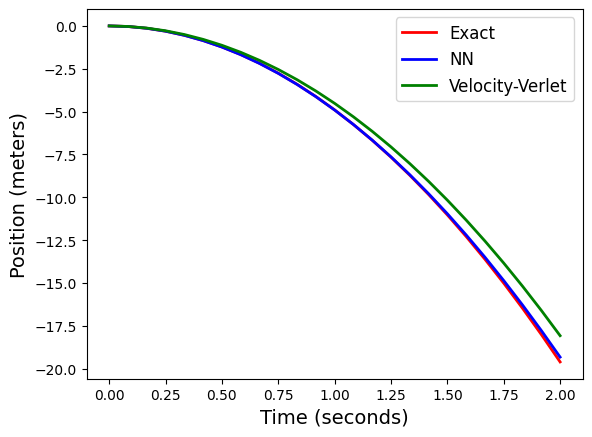

In [12]:
plt.plot(t, y_exact,linewidth=2,color="red",label="Exact") 
plt.plot(t, y_nn,linewidth=2,color="blue",label="NN")
plt.plot(t,y_vv,linewidth=2,color="green",label="Velocity-Verlet")
plt.legend(fontsize=12)
plt.xlabel("Time (seconds)",fontsize=14)
plt.ylabel("Position (meters)",fontsize=14)

Finally, let's calculate the RMSE error between the exact position and the position approximated by the neural network and the exact position and the position approximated by the Velocity-Verlet method.

In [13]:
print("RMSE of the Velocity-Verlet Solution:", rmse(y_vv,y_exact))
print("RMSE of the Neural Network Solution:", rmse(y_exact,y_nn))

RMSE of the Velocity-Verlet Solution: 0.70630900830357
RMSE of the Neural Network Solution: 0.09494330770895291


**EXERCISE 1**: In your opinion, does the Velocity-Verlet method or the neural network approximation work better for modelling the position of an object given its acceleration.  Consider not just accuracy but also other factors such as run time and complexity.

Delete this text and add your answer here.

## Improving the Accuracy of the Neural Network

### Hyperparameter Tuning

One of the easiest (though time consuming) methods to improve the accuracy of a neural network is through a process known as hyperparameter tuning.  The output of a neural network depends on many factors, three of which being the learning rate, the number of training iterations, and the number of neurons in each hidden layer.  Hyperparameter tuning is a process through which we train the network using various combinations of values for these parameters to see which combination gives us the best results.

The below code cell runs a small hyperparameter tuning process on our neural network.  Note that even though only three options are used for the learning rate, the number of training iterations, and the number of neurons in the hidden layer we will be training and analyzing 27 different neural networks, so this is a time consuming process even with a small number of options.

**WARNING**: The below cell will take a long time to run!

In [14]:
best_err = 100
best_lr = None
best_num = None
best_neurons = None
for lr in [0.0001, 0.001, 0.01]:
    for num in [25, 50, 100]:
        for neurons in [2, 5, 10]:
            W = [npr.normal(key,(1, neurons)), npr.normal(key,(neurons, 1))]
            for i in range(num):
                loss_grad =  grad(loss_function)(W, t)

                W[0] = W[0] - lr * loss_grad[0]
                W[1] = W[1] - lr * loss_grad[1]
            res = [y_trial(ti, neural_network(W, ti)[0][0]) for ti in t] 
            err = rmse(y_exact,res)
            print("Hyperparameter Combination and Error: (",lr, num,neurons,")",err)
            if err < best_err:
                best_err = err
                best_lr = lr
                best_num = num
                best_neurons = neurons
print("Best Hyperparameter Combination and Error: (",best_lr, best_num, best_neurons,")",best_err)          

Hyperparameter Combination and Error: ( 0.0001 25 2 ) 6.825785639881246


Hyperparameter Combination and Error: ( 0.0001 25 5 ) 4.634791661544085


Hyperparameter Combination and Error: ( 0.0001 25 10 ) 2.609767987482142


**EXERCISE 2:** What was the optimal set of parameters and what was the associated RMSE error?  In your opinion, does the decrease in RMSE justify the time needed for the hyperparameter tuning?

Delete this text and add your answer here.

Though we are only tuning three different hyperparameter here, there are many more options we could consider.  Things like the number of hidden layers, the number of neurons per hidden layer, and the activation function per hidden layer are all hyperparameters that could be adjusted to improve the accuracy of a neural network.

### Smaller Time Step

As seen on the first notebook of this module (Notebook 1: Solving Differential Equations Numerically), a smaller time step makes the numerical differential equation solvers more accurate.  However, this does come with an increased run time.

The same should be true for our neural network solution (a smaller step size leads to a greater accuracy but a longer run time).  Let's test that below using a step size that is 4x smaller than previously used.

In [ ]:
# Define the constants: linear drag coefficient and mass
b = 0.001
m = 1.0

# Define the number of time steps, the final time, and the time step (all in seconds)
nt = 100
tfinal = 2
dt = tfinal/nt

# Define the time array and generate the exact solution and the numerical solution
# using velocity-verlet
t = np.linspace(0, tfinal, nt)    

# Generate the key random number
key = npr.PRNGKey(0)
# Set the number of neurons in the hidden layer
number_hidden_neurons = 10
# Initialize the weights of the neural network with random numbers
W = [npr.normal(key,(1, number_hidden_neurons)), npr.normal(key,(number_hidden_neurons, 1))]

# Set the learning rate and the number of training iterations for the network
learning_rate = 0.001
num_training_iterations = 25

# Train the neural network for the specified number of iterations
# Update the weights using the learning rates
for i in range(num_training_iterations):
    loss_grad =  grad(loss_function)(W, t)
    W[0] = W[0] - learning_rate * loss_grad[0]
    W[1] = W[1] - learning_rate * loss_grad[1]

# Calculate the exact solution at every t value
y_exact = y_analytic(t,b,m)
# Approximate the position using Velocity-Verlet at every t value
y_vv = velocity_verlet (b,m,dt,tfinal)
# Use the trained neural network to generate the predicted results for y at
# every t value
y_nn = [y_trial(ti, neural_network(W, ti)[0][0]) for ti in t]   

# Analyze the RMSE of both errors compared to the exact solution
print("RMSE of the Velocity-Verlet Solution:", rmse(y_vv,y_exact))
print("RMSE of the Neural Network Solution:", rmse(y_exact,y_nn))



RMSE of the Velocity-Verlet Solution: 0.17338892752467963
RMSE of the Neural Network Solution: 0.895014010662905


**EXERCISE 3**: In your opinion was this error significantly low enough to justify the time needed to decrease the step size?  Consider this for both the neural network and the Velocity-Verlet results.

Delete this text and add your answer here.

**EXERCISE 4:** Change the above code to have the optimal set of hyperparameters found above.  Does this improve the result from the neural network?

Delete this text and add your answer here.

## Practice What You Have Learned

Using the above notebook as a guide, complete the following exercises.
1. Consider a box sliding across a rough surface.  The box is given a push such that its initial velocity is 10m/s and the coefficient of static friction between the box and the surface is 0.01.  What is the analytical expression for the motion of the box?  How long does it take until the box will stop moving (this will be our tfinal)?
2. Create a function that will produce the analytical position of the box at a given time.  Consider what other parameters may need to be arguments of this function as well (mass of box, kinetic coefficient of friction, etc.).
3. Create a function that numerically solves for the position of the box using the Velocity-Verlet method.  What should be the arguments to this function?
4. Considering the initial conditions of the box (y$_0$ = 0m and v$_0$ = 10m/s), what should the trial solution for the neural network solution be?  Create a function called y_trial with your answer (use the above y_trial function as a guide).  
5. Using the loss function and neural network training code above (just copy and paste it below), train a neural network for your new system.  How do the results of your neural network compare to the exact solution and to the Velocity-Verlet solution?
6. Are you happy with the results from your neural network?  If not, try to use a combination of hyperparameter tuning and reducing the step size to improve your results.
7. As the coefficient of kinetic friction is increase, the position of the box as a function of time should become less linear and more quadratic.  Rerun your code with a kinetic coefficient of friction of 0.1 and then 1.0.  How does increasing this coefficient change the accuracy of the Velocity-Verlet and neural network results?
